In [2]:
import torch
from torch.utils.data import Dataset
import pickle
import numpy as np


In [3]:
def create_index(pickle_file, index_file):
    offsets = []
    with open(pickle_file, 'rb') as file:
        while True:
            offset = file.tell()
            try:
                pickle.load(file)
                offsets.append(offset)
            except EOFError:
                break
    with open(index_file, 'wb') as file:
        pickle.dump(offsets, file)

# Usage
create_index('../pipeline/data/U_500.pkl', 'training.idx')


In [55]:
from torch.utils.data import DataLoader, random_split
from dataset import LazyChemDataset


lazy_chem_dataset = LazyChemDataset('../pipeline/data/U_500.pkl', 'training.idx')
lazy_chem_dataloader = DataLoader(lazy_chem_dataset, batch_size=200, shuffle=True)
train_size = int(0.8 * len(lazy_chem_dataset))
val_size = len(lazy_chem_dataset) - train_size

lazy_chem_dataloader, val_dataloader = random_split(lazy_chem_dataset, [train_size, val_size])


In [50]:
import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(1781, 1500)
        self.fc2 = nn.Linear(1500, 1500)
        # self.fc3 = nn.Linear(1500, 1500)
        self.fc4 = nn.Linear(1500, 500)
        
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc4(x))
        out = self.softmax(self.fc4(x))
        return out


In [51]:
model = MyModel()

# Assuming you are using a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss Function
loss_function = nn.CrossEntropyLoss()


In [68]:
def train_model(model, loss_function, optimizer, num_epochs):
    model.train()  # Set the model to training mode
    losses = []
    accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in lazy_chem_dataloader:
            # Move data to the appropriate device
            inputs = inputs.to(device).reshape(-1, 1781)
            labels = labels.to(device).long()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        # Print average loss and accuracy for the epoch
        epoch_loss = running_loss / len(lazy_chem_dataloader)
        epoch_acc = correct_predictions / total_predictions
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    print('Finished Training')
    return losses, accuracies


In [69]:
loss = []
accuracy = []

In [70]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)

new_loss, new_acc = train_model(model, loss_function, optimizer, 20)
loss += new_loss
accuracy += new_acc

Epoch [1/20], Loss: 4.8342, Accuracy: 0.0350
Epoch [2/20], Loss: 3.7825, Accuracy: 0.1400
Epoch [3/20], Loss: 3.0313, Accuracy: 0.2475
Epoch [4/20], Loss: 2.4235, Accuracy: 0.3650
Epoch [5/20], Loss: 1.9775, Accuracy: 0.4475
Epoch [6/20], Loss: 1.6752, Accuracy: 0.4900
Epoch [7/20], Loss: 1.4654, Accuracy: 0.5450
Epoch [8/20], Loss: 1.3097, Accuracy: 0.5725
Epoch [9/20], Loss: 1.2206, Accuracy: 0.5925
Epoch [10/20], Loss: 1.1475, Accuracy: 0.6225
Epoch [11/20], Loss: 1.0789, Accuracy: 0.6525
Epoch [12/20], Loss: 1.0262, Accuracy: 0.6550
Epoch [13/20], Loss: 1.0590, Accuracy: 0.6600
Epoch [14/20], Loss: 0.9876, Accuracy: 0.6750
Epoch [15/20], Loss: 0.9561, Accuracy: 0.6825
Epoch [16/20], Loss: 0.9486, Accuracy: 0.7050
Epoch [17/20], Loss: 0.9260, Accuracy: 0.7200
Epoch [18/20], Loss: 0.8852, Accuracy: 0.7250
Epoch [19/20], Loss: 0.9501, Accuracy: 0.7175
Epoch [20/20], Loss: 0.8669, Accuracy: 0.7275
Finished Training


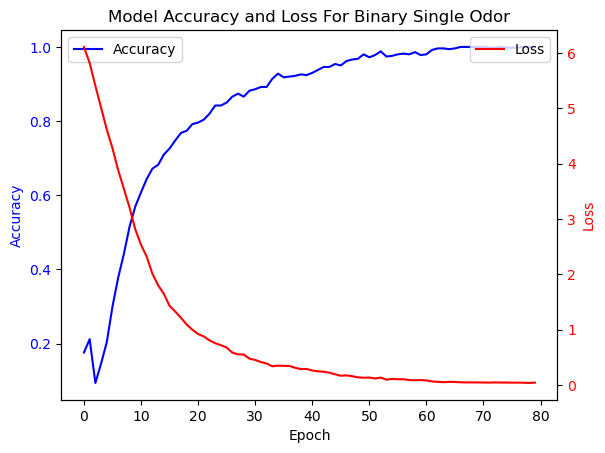

In [311]:
import matplotlib.pyplot as plt

epochs = range(len(loss))
# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plotting the accuracy on the primary y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
ax1.plot(epochs, accuracy, color='blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a second y-axis for the loss
ax2 = ax1.twinx()  
ax2.set_ylabel('Loss', color='red')  
ax2.plot(epochs, loss, color='red', label='Loss')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# Show the plot
plt.title('Model Accuracy and Loss For Binary Single Odor')
plt.show()

In [298]:
torch.save(model.state_dict(), 'mixture_1_unif.pt')

In [326]:
odors = [lazy_chem_dataset[id][0] for id in [0, 1]]
mixture = sum(odors).reshape(1, -1)
output = model(mixture).detach().numpy()
top_n_preds = np.argsort(output)[-1:]
# model(mixture)[0]
top_n_preds

array([[441, 443, 296, 428, 493, 406, 424, 119, 417, 467, 319, 432, 299,
        436, 375, 437,  94, 478, 460, 475, 404, 459, 425, 168, 423, 300,
        492, 461, 420, 474, 416, 469,  99, 105, 491, 401, 315, 468, 447,
        409, 480, 451, 412, 448, 157, 100, 465, 410, 456, 217, 421, 481,
         86, 127, 182,   8, 359, 178, 413, 191, 453, 167, 307, 247, 438,
        434, 361, 396, 445, 471, 429, 444, 440, 426, 234, 304, 414,  97,
        499, 446, 211, 433, 143, 457, 452, 129, 466, 125, 110, 376, 323,
        108, 454, 222, 377, 427, 251,  82, 497, 223, 293, 141, 214, 169,
        330, 160, 104, 387, 422, 408,  15, 332,  68, 435, 463,  71, 430,
        391, 449, 379, 183, 122, 458, 266, 112, 132, 130,  95, 246, 407,
        102, 333, 298, 353, 339, 291, 439, 120, 483, 156, 472, 383, 187,
         75, 198, 114,  80, 321, 263, 381,  43,  96, 338, 208,  92, 111,
        487, 260, 350, 113, 212, 464,  69, 450, 490, 399, 334, 418, 193,
        103, 488,  98, 242, 225, 484, 159, 241, 106

## Testing

In [9]:
# load mixture_1_unif.pt in model
model = MyModel()
model.load_state_dict(torch.load('mixture_1_unif.pt'))
model.eval()


MyModel(
  (fc1): Linear(in_features=1781, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=1500, bias=True)
  (fc4): Linear(in_features=1500, out_features=500, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax(dim=1)
)

In [41]:
# Testing pre-trained model on mixtures of 2
import random
n_tests = 1000
untrained_model = MyModel()

def test(mixture_size, top_n, model):
  running_1corrects = 0
  running_corrects = 0
  for i in range(n_tests):
    if i % 100 == 0:
      print(i)
    
    indices = []
    for _ in range(mixture_size):
      new_i = random.randint(0, 499)
      while new_i in indices:
        new_i = random.randint(0, 499)
      indices.append(new_i)

    odors = [lazy_chem_dataset[id][0] for id in indices]
    mixture = sum(odors).reshape(1, -1)
    output = model(mixture).detach().numpy()
    top_n_preds = np.argsort(output[0])[-top_n:]

    res = [id in top_n_preds for id in indices]
    running_corrects += sum(res)/mixture_size
    if any([id in top_n_preds for id in indices]):
      running_1corrects += 1
  print(f"Accuracy: {running_corrects/n_tests}")
  print(f"Accuracy (at least 1 corect): {running_1corrects/n_tests}")
  return running_corrects/n_tests, running_1corrects/n_tests


In [42]:
accuracy = { 1: [], 2: [], 3: []}
untrained_acc = { 1: [], 2: [], 3: []}

In [43]:
for i in [1, 2, 3]: # mixture number
    for j in range(i, 10): # top_n number:
        print(i, j)
        acc, one_acc = test(i, j, model)
        accuracy[i].append(acc)

        acc, one_acc = test(i, j, untrained_model)
        untrained_acc[i].append(acc)

1 1
0
100
200
300
400
500
600
700
800
900
Accuracy: 1.0
Accuracy (at least 1 corect): 1.0
0
100
200
300
400
500
600
700
800
900
Accuracy: 0.008
Accuracy (at least 1 corect): 0.008
1 2
0
100
200
300
400
500
600
700
800
900
Accuracy: 1.0
Accuracy (at least 1 corect): 1.0
0
100
200
300
400
500
600
700
800
900
Accuracy: 0.01
Accuracy (at least 1 corect): 0.01
1 3
0
100
200
300
400
500
600
700
800
900
Accuracy: 1.0
Accuracy (at least 1 corect): 1.0
0
100
200
300
400
500
600
700
800
900
Accuracy: 0.011
Accuracy (at least 1 corect): 0.011
1 4
0
100
200
300
400
500
600
700
800
900
Accuracy: 1.0
Accuracy (at least 1 corect): 1.0
0
100
200
300
400
500
600
700
800
900
Accuracy: 0.01
Accuracy (at least 1 corect): 0.01
1 5
0
100
200
300
400
500
600
700
800
900
Accuracy: 1.0
Accuracy (at least 1 corect): 1.0
0
100
200
300
400
500
600
700
800
900
Accuracy: 0.011
Accuracy (at least 1 corect): 0.011
1 6
0
100
200
300
400
500
600
700
800
900
Accuracy: 1.0
Accuracy (at least 1 corect): 1.0
0
100
200
300


In [44]:
print(accuracy)

{1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 2: [0.5445, 0.5935, 0.602, 0.64, 0.6425, 0.669, 0.669, 0.684], 3: [0.375333333333331, 0.41933333333333084, 0.4229999999999977, 0.44833333333333214, 0.46199999999999847, 0.46633333333333216, 0.48666666666666536]}


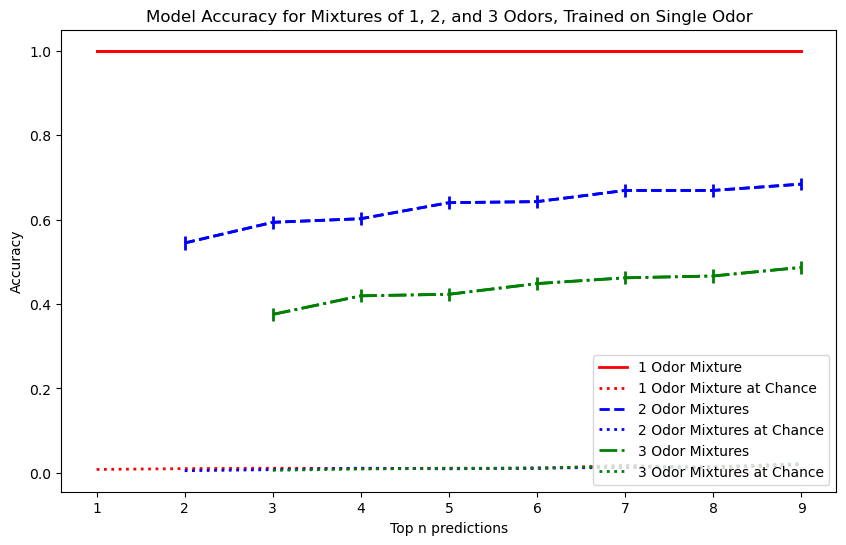

In [48]:
import matplotlib.pyplot as plt
import numpy as np


# separate y values
mix_1 = accuracy[1]
mix_2 = accuracy[2]
mix_3 = accuracy[3]

untrained_1 = untrained_acc[1]
untrained_2 = untrained_acc[2]
untrained_3 = untrained_acc[3]


plt.figure(figsize=(10, 6))  # Set the figure size

def std_devs(lst):
    return [np.sqrt(p*(1-p)/1000) for p in lst]

plt.errorbar(range(1, 10), mix_1, yerr=std_devs(mix_1), color='red', linestyle='-', linewidth=2)
plt.plot(range(1, 10), mix_1, label='1 Odor Mixture', color='red', linestyle='-', linewidth=2)
plt.plot(range(1, 10), untrained_1, label='1 Odor Mixture at Chance', color='red', linestyle=':', linewidth=2)

plt.errorbar(range(2, 10), mix_2, yerr=std_devs(mix_2), color='blue', linestyle='--', linewidth=2)
plt.plot(range(2, 10), mix_2, label='2 Odor Mixtures', color='blue', linestyle='--', linewidth=2)
plt.plot(range(2, 10), untrained_2, label='2 Odor Mixtures at Chance', color='blue', linestyle=':', linewidth=2)

plt.errorbar(range(3, 10), mix_3, yerr=std_devs(mix_3), color='green', linestyle='-.', linewidth=2)
plt.plot(range(3, 10), mix_3, label='3 Odor Mixtures', color='green', linestyle='-.', linewidth=2)
plt.plot(range(3, 10), untrained_3, label='3 Odor Mixtures at Chance', color='green', linestyle=':', linewidth=2)

plt.xlabel('Top n predictions')
plt.ylabel('Accuracy')

plt.title('Model Accuracy for Mixtures of 1, 2, and 3 Odors, Trained on Single Odor')


# put legend in bottom right
plt.legend(loc='lower right')
plt.show()


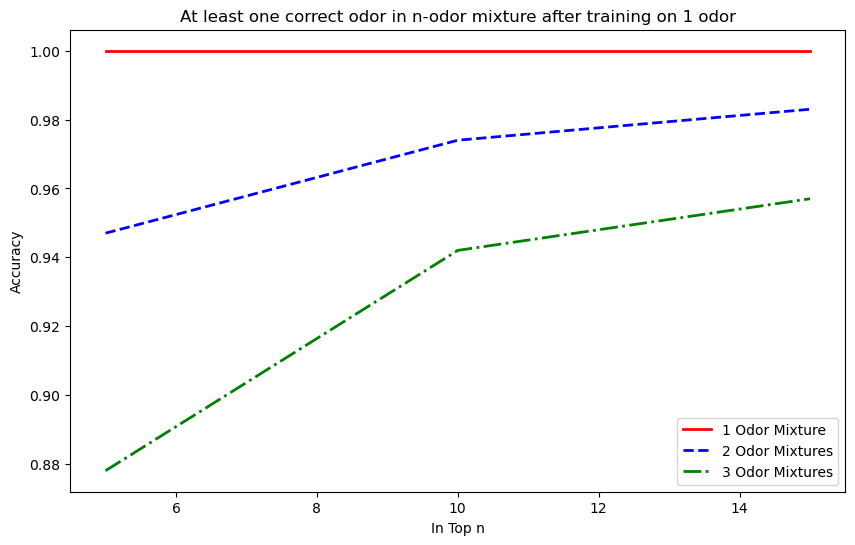

In [351]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values
x = [5, 10, 15]  # Generate 100 points between 0 and 10

# Generate y values for three different functions
mix_1 = at_least_1_accuracy[0:3]
mix_2 = at_least_1_accuracy[3:6]
mix_3 = at_least_1_accuracy[6:9]

# Create a plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot each line with specific styles
plt.plot(x, mix_1, label='1 Odor Mixture', color='red', linestyle='-', linewidth=2)  # Red solid line for sine
plt.plot(x, mix_2, label='2 Odor Mixtures', color='blue', linestyle='--', linewidth=2) # Blue dashed line for cosine
plt.plot(x, mix_3, label='3 Odor Mixtures', color='green', linestyle='-.', linewidth=2)  # Green dash-dot line for square

# Adding labels and title
plt.xlabel('In Top n')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.title('At least one correct odor in n-odor mixture after training on 1 odor')  # Title of the graph

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()
